In [22]:
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [23]:
signal1 = []
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm1.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm2.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm3.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm4.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm5.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm6.mat"))

In [24]:
data = []
for dat in signal1[:6]:
    data.append(dat["X"])

In [25]:
dataList = []
for index_example in range(100):
    frame = pd.DataFrame()
    for index_feature in range(6):
        if len(frame.index) > 0 :
            frame[index_feature] = pd.DataFrame(data[index_feature][index_example])
        else:
            frame = pd.DataFrame(data[index_feature][index_example])
    dataList.append(frame)
    

In [26]:
data_U = []    
for dat in signal1[:6]:
    data_U.append(dat["U"])
dataList_U = []
for index_example in range(100):
    frame = pd.DataFrame()
    for index_feature in range(6):
        if len(frame.index) > 0 :
            frame[index_feature] = pd.DataFrame(data_U[index_feature][index_example])
        else:
            frame = pd.DataFrame(data_U[index_feature][index_example])
    dataList_U.append(frame)

<AxesSubplot:>

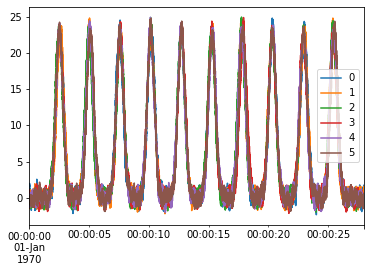

In [29]:
dataList[0].plot()

2 Signale, 100 Beispiele, 6 Merkmale (Kanäle). Zeitachse: -23s ... 5s, Abtastrate: 500 Werte pro Sekunde.

In [28]:
dataList_not_sampled = dataList.copy()
for i,df in enumerate(dataList):
    df.index = pd.to_datetime(
        np.arange(0, len(df.index)*2, 2).tolist(),
        unit="ms")
    dataList[i] = df#.resample("100ms").mean()

In [77]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Turns a timeseries into a supervised series
    which can be used with supvervised learning methods

    Args:
        data ([type]): Usually a dataframe
        n_in (int, optional): Lag of the input. Defaults to 1.
        n_out (int, optional): how many Timesteps forecast into the future. Defaults to 1.
        dropnan (bool, optional): Drop rows that contain NaN values. Defaults to True.

    Returns:
        Dataframe: Dataframe with lag and output
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(data.columns[j], i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(data.columns[j]))
                      for j in range(n_vars)]
        else:
            names += [('{}(t+{})'.format(data.columns[j], i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
def getXandY(df_temp):
    dataframe = pd.DataFrame(df_temp)
    
    dataframe.index = df_temp.index

    dataframe_shifted = series_to_supervised(dataframe,Timesteps_past-1,Timesteps_future+1)

    X_dataframe = dataframe_shifted[dataframe_shifted.columns.drop(list(dataframe_shifted.filter(regex='\+')))]
    y_dataframe = dataframe_shifted.filter(regex='\(t\+')

    X_dataframe = X_dataframe.to_numpy()
    y_dataframe = y_dataframe.to_numpy()


    X_dataframe = X_dataframe.reshape(X_dataframe.shape[0], Timesteps_past, Features) # (samples, time steps, features).

    y_dataframe = y_dataframe.reshape(y_dataframe.shape[0], Timesteps_future, Features) # (samples, time steps, features).

    #print(X_dataframe.shape,y_dataframe.shape)

    return X_dataframe, y_dataframe, dataframe_shifted

In [77]:
def series_to_supervised_modified(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    x, y = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        x.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        y.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [76]:
df = dataList[0][-7600:-2500]
df = series_to_supervised(df,2500-1,2500+1)
X_dataframe = df[df.columns.drop(list(df.filter(regex='\+')))]
y_dataframe = df.filter(regex='\(t\+')
X_dataframe = X_dataframe.to_numpy()
y_dataframe = y_dataframe.to_numpy()
print(X_dataframe.shape,y_dataframe.shape)

(101, 15000) (101, 15000)


In [73]:
X_dataframe

,0(t-2499),1(t-2499),2(t-2499),3(t-2499),4(t-2499),5(t-2499),0(t-2498),1(t-2498),2(t-2498),3(t-2498),...,2(t-1),3(t-1),4(t-1),5(t-1),0(t),1(t),2(t),3(t),4(t),5(t)
1970-01-01 00:00:18,13.48432,14.958836,13.421904,16.679996,13.72418,14.086592,13.235067,15.252954,12.292636,16.49035,...,16.06261,21.586504,17.572469,20.822394,17.450255,17.355552,15.192438,21.567984,17.344143,20.868532


Second way


In [32]:
Timesteps_past = 11_500
Features = 6
Timesteps_future = 2500

In [78]:
from keras.preprocessing import timeseries_dataset_from_array
for df in dataList[:1]:
    ddd = timeseries_dataset_from_array(
        np.asarray(df[:-2500]),
        np.asarray(df[:-2500]),
        sequence_length=2500,

    )

In [80]:
np.asarray(df[:-2500]).shape

(11501, 6)

In [55]:
for batch in ddd:
    x, y = batch
    print(x.shape, y.shape)
y

(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (128, 6)
(128, 2500, 6) (

<tf.Tensor: shape=(42, 6), dtype=float64, numpy=
array([[20.0846872 , 20.28646465, 19.19706487, 23.96732299, 20.19219038,
        22.18195867],
       [20.26574681, 19.781665  , 19.0486806 , 23.4845621 , 19.54923511,
        22.78569509],
       [20.01141582, 19.38461948, 19.19138655, 22.7499112 , 19.76523706,
        21.81596102],
       [20.14280972, 19.72918955, 18.9995346 , 24.89038599, 20.13922756,
        22.6255965 ],
       [19.71033473, 20.16907728, 18.99874429, 23.97955989, 19.82457445,
        21.53181113],
       [20.52606153, 19.12212991, 18.909529  , 24.43587962, 19.13310647,
        22.82912074],
       [19.88518253, 18.93143432, 18.63458461, 23.40605091, 19.45800489,
        22.73136825],
       [20.2729978 , 20.9064445 , 18.20949464, 22.80483151, 20.27686479,
        22.57331736],
       [20.53054098, 19.29101499, 18.34125965, 23.10486053, 19.36172097,
        21.72750197],
       [19.832459  , 19.93700298, 17.49878528, 22.95860736, 20.26399386,
        22.74668345],
 

In [14]:
X_train = []
y_train = []
for df in dataList[:1]:
    X, y, train_shifted = getXandY(df[:-2500])
    for i in range(len(X)):
        X_train.append(X[i])
        y_train.append(y[i])
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
print(X_train.shape, y_train.shape)

(1, 2500, 6) (1, 2500, 6)


In [16]:
X_test = []
y_test= []
for df in dataList[99:]:
    X, y, train_shifted = getXandY(df[-5000:])
    for i in range(len(X)):
        X_test.append(X[i])
        y_test.append(y[i])
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print(X_test.shape, y_test.shape)

(1, 2500, 6) (1, 2500, 6)


In [13]:
X_valid = []
y_valid= []
for df in dataList[95:]:
    df = df[-100:]
    X, y, train_shifted = getXandY(df)
    X_valid.append(X[0])
    y_valid.append(y[0])
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
print(X_valid.shape, y_valid.shape)

(5, 50, 6) (5, 50, 6)


In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(100, 6)))
model.add(LSTM(10, activation='relu'))
model.add(Dense(units=50*6))
model.add(Reshape((50, 6)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          42800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense (Dense)                (None, 300)               3300      
_________________________________________________________________
reshape (Reshape)            (None, 50, 6)             0         
Total params: 50,540
Trainable params: 50,540
Non-trainable params: 0
_________________________________________________________________


In [15]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_valid_original = X_valid.copy()
y_train_original = y_train.copy()
y_test_original = y_test.copy()
y_valid_original = y_valid.copy()

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# Scale X
scaler_X= RobustScaler()
X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test= scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_valid = scaler_X.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
# Scale y
scaler_y= RobustScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)
y_valid = scaler_y.transform(y_valid.reshape(-1, y_valid.shape[-1])).reshape(y_valid.shape)


In [18]:
model.fit(X_train,y_train,epochs=2,verbose=1)

Epoch 1/2
541/541 [==============================] - 42s 75ms/step - loss: 0.2039
Epoch 2/2
541/541 [==============================] - 39s 73ms/step - loss: 0.0184


Settings
!! Data got resampled to 100ms steps
   Timesteps_ past: 50
   Timesteps_ future: 50
-> Evaluation:
   Mean squared error: 0.023494136538879284
   Mean absolute error: 0.10457921555707389
-> Evaluation after Rescaling:
   Mean squared error: 3.791202071842242
   Mean absolute error: 1.3286085258233524


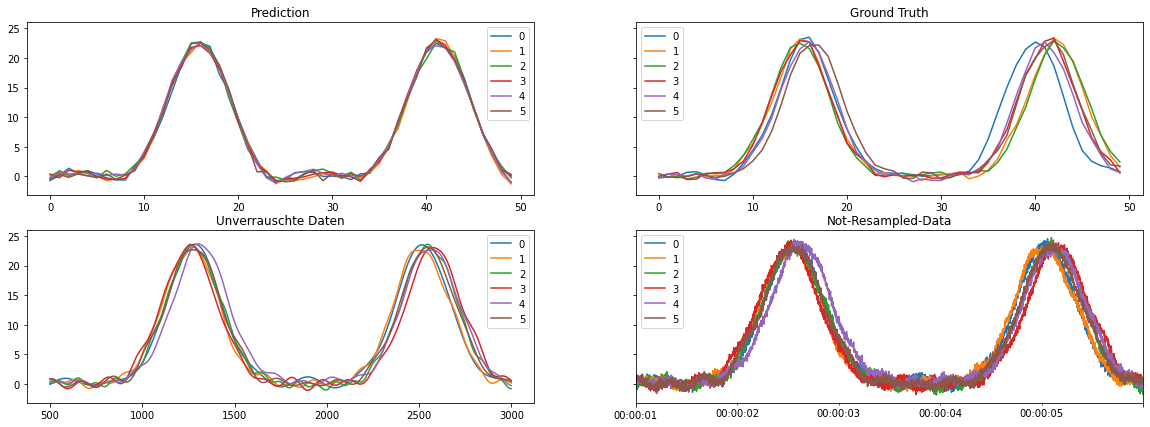

In [21]:
predictions = model.predict(X_test)
predictions_rescaled  = scaler_y.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)
from sklearn.metrics import mean_squared_error, mean_absolute_error
i = 1

print("Settings")
print("!! Data got resampled to 100ms steps")
print("   Timesteps_ past: {}".format(Timesteps_past))
print("   Timesteps_ future: {}".format(Timesteps_future))
print("-> Evaluation:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions[i], y_test[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions[i], y_test[i])))
print("-> Evaluation after Rescaling:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions_rescaled[i], y_test_original[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions_rescaled[i], y_test_original[i])))
for i in range(1):
    f, ((ax1, ax2),( ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(20,7))
    pd.DataFrame(predictions_rescaled[10]).plot(ax = ax1)
    pd.DataFrame(y_test_original[10]).plot(ax=ax2)
    pd.DataFrame(dataList_U[95][500:3000]).plot(ax=ax3)
    pd.DataFrame(dataList_not_sampled[95][500:3000]).plot(ax=ax4)
    ax1.title.set_text('Prediction')
    ax2.title.set_text('Ground Truth')
    ax3.title.set_text('Unverrauschte Daten')
    ax4.title.set_text('Not-Resampled-Data')

Settings
!! Data got resampled to 100ms steps
   Timesteps_ past: 50
   Timesteps_ future: 50
Evaluation:
   Mean squared error: 0.18004983177617517
   Mean absolute error: 0.2073006347322056
Evaluation after Rescaling:
   Mean squared error: 29.05915791704435
   Mean absolute error: 2.633657909599592


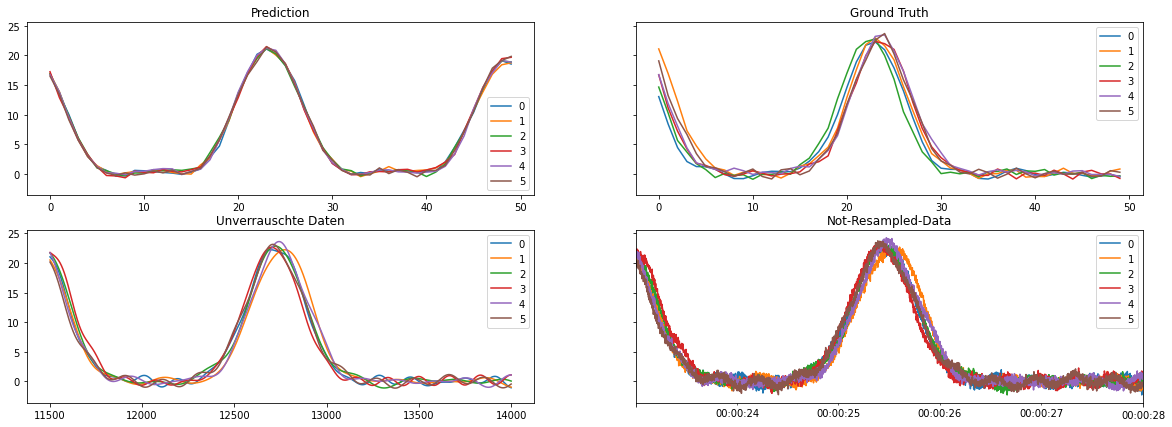

In [20]:
predictions = model.predict(X_valid)
predictions_rescaled  = scaler_y.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)
from sklearn.metrics import mean_squared_error, mean_absolute_error
i = 3
print("Settings")
print("!! Data got resampled to 100ms steps")
print("   Timesteps_ past: {}".format(Timesteps_past))
print("   Timesteps_ future: {}".format(Timesteps_future))
print("Evaluation:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions[i], y_valid[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions[i], y_valid[i])))
print("Evaluation after Rescaling:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions_rescaled[i], y_valid_original[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions_rescaled[i], y_valid_original[i])))
for i in range(1):
    f, ((ax1, ax2),( ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(20,7))
    pd.DataFrame(predictions_rescaled[i]).plot(ax = ax1)
    pd.DataFrame(y_valid_original[i]).plot(ax=ax2)
    pd.DataFrame(dataList_U[96+i][-2500:]).plot(ax=ax3)
    pd.DataFrame(dataList_not_sampled [96+i][-2500:]).plot(ax=ax4)
    ax1.title.set_text('Prediction')
    ax2.title.set_text('Ground Truth')
    ax3.title.set_text('Unverrauschte Daten')
    ax4.title.set_text('Not-Resampled-Data')